In [1]:
import numpy as np
import pandas as pd
import os
import struct
from sklearn.datasets import fetch_mldata
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

path = os.path.join(os.getcwd(), 'datasets')
def load_mnist(path, kind):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels.idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images.idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)
 
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels
train_images, train_labels = load_mnist(path, 'train')
test_images, test_labels = load_mnist(path, 't10k')

'''显示测试集中的一幅图像'''
some_data = train_images[40000]
some_data_image = some_data.reshape(28, 28)
plt.imshow(some_data_image, cmap=plt.cm.binary, interpolation='nearest')  # interpolation差值
plt.axis('off')  # 隐藏坐标轴
plt.show()

'''一些模型对数据的排序敏感，因此在训练之前先将数据的顺序打乱'''
shuffle_train_index = np.random.permutation(60000)  # permutation排序
x_train, y_train = train_images[shuffle_train_index], train_labels[shuffle_train_index]
shuffle_test_index = np.random.permutation(10000)
x_test, y_test = test_images[shuffle_test_index], test_labels[shuffle_test_index]

X_train = np.r_[x_train[y_train == 1], x_train[y_train == 7]]
y_train = np.r_[y_train[y_train == 1], y_train[y_train == 7]]
X_test = np.r_[x_test[y_test == 1], x_test[y_test == 7]]
y_test = np.r_[y_test[y_test == 1], y_test[y_test == 7]]
X_train = X_train.T / 255 # 讲训练集进行转置，使得每一列表示一个样本
X_test = X_test.T / 255
y_train[y_train == 1] = 1
y_train[y_train == 7] = 0
y_test[y_test == 1] = 1
y_test[y_test == 7] = 0
y_train = y_train.reshape(1, y_train.size)
y_test = y_test.reshape(1, y_test.size)

#X.shape (64, 289) y_train.shape (1, 289) W.shape (dim, 1) b.shape 1 Z.shape=A.shape (1, 289)
#定义sigmoid激活函数
def sigmoid(z):
    return 1 / (1+np.exp(-z))
#定义ReLU激活函数
def Relu(z):
    z = np.where(z>0, z, 0)
    return z
#初始化 dim为W参数的个数(属性的个数)
def initialize(dim):
    W = np.random.randn(dim, 1) / 100
    b = 0
    return W, b
#前向传播以及反向传播
def propagate(W, b, X, Y):
    m = X_train.shape[1]
    #forward propagation
    Z = np.dot(W.T, X) + b
    A = sigmoid(Z)
    #print(A)
    cost = - (1 / m) * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
    #back propagation
    dw = (1/m) * np.dot(X, (A-Y).T)
    db = (1/m) * np.sum(A-Y)
    #print(dw)
    #讲dw和db保存为字典输出
    grads = {'dw': dw,
             'db': db}
    return grads, cost

def optimize(W, b, X, Y, num_iterations, learning_rate, print_cost=False):
#gradient descent and updata paremeters
#output : W, b所组成的字典, 保存每次迭代的cost
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(W, b, X_train, y_train)
        W = W - learning_rate * grads['dw']
        b = b - learning_rate * grads['db']
        #print(grads['dw'])
        costs.append(cost)
        if (i % 100 == 0) and (print_cost == True):
            print('迭代次数：%i, cost: %f' % (i, cost))
        params = {'W': W,
                  'b': b}
    return params, costs
    
def predict(W, b, X):
    #输出预测
    m = X.shape[1]
    y = np.zeros((1, m))
    Z = np.dot(W.T, X) + b
    A = sigmoid(Z)
    for i in range(A.shape[1]):
        y[0, i] = 0 if A[0, i] < 0.5 else 1
    return np.array(y, dtype=np.int)


W, b = initialize(X_train.shape[0])
params, costs = optimize(W, b, X_train, y_train, 500, 0.5, False)
y_train_predict = predict(params['W'], params['b'], X_train)
print(accuracy_score(y_train.reshape(y_train.shape[1]), y_train_predict.reshape(y_train.shape[1])))
plt.figure()
costs = np.array(costs)
plt.plot(np.linspace(0, costs.shape[0], costs.shape[0]), costs)
plt.show()

<Figure size 640x480 with 1 Axes>

0.9950795725378643


<Figure size 640x480 with 1 Axes>

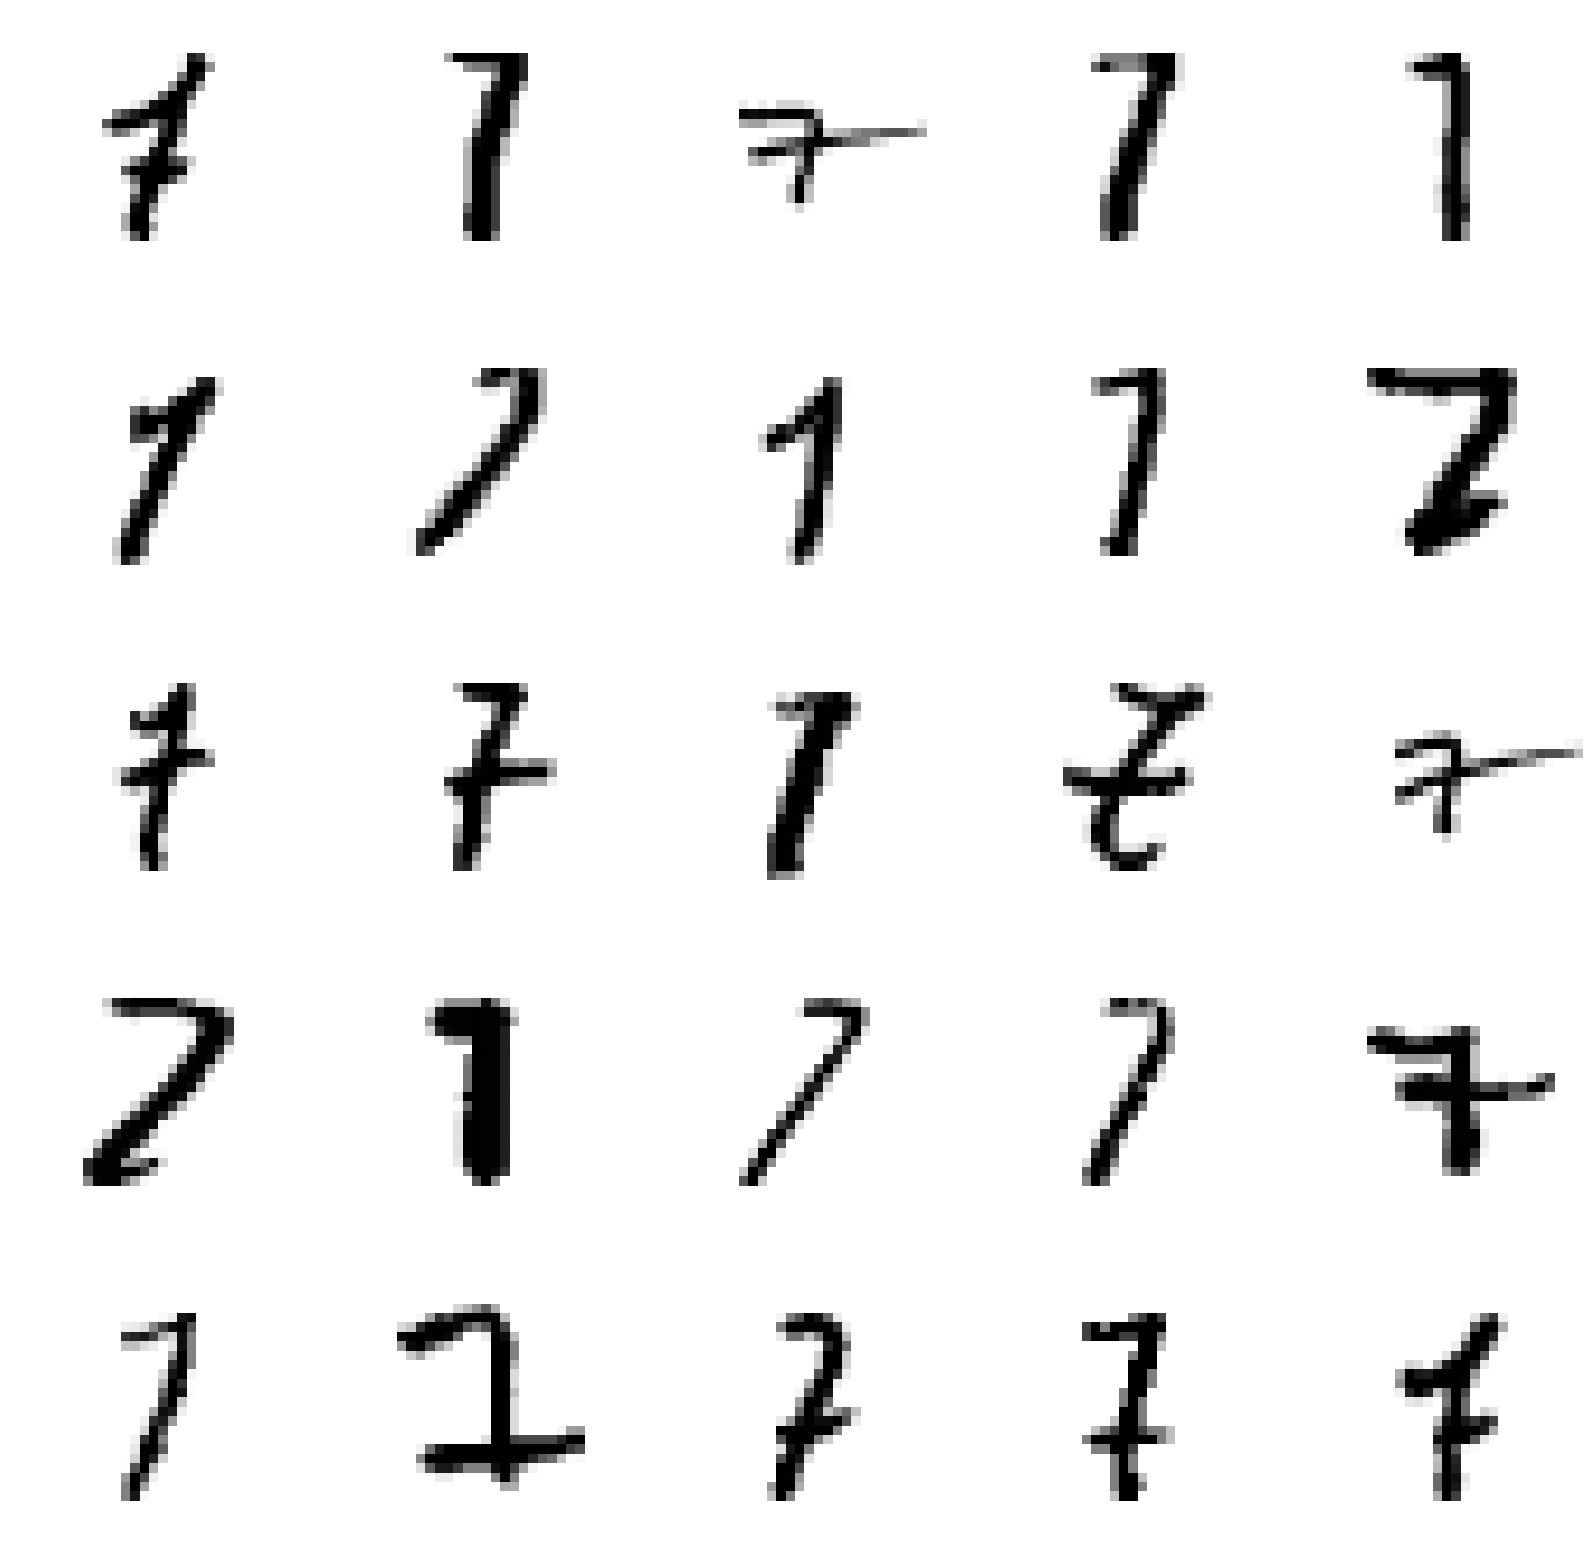

In [2]:
'''显示错误分类的图片进行观察'''
cl_a, cl_b = 1, 0
X_aa = X_train.T[((y_train == cl_a) & (y_train_predict == cl_a)).reshape(13007)] 
X_ab = X_train.T[((y_train == cl_a) & (y_train_predict == cl_b)).reshape(13007)] # 被错误分类为5的3的图片
X_ba = X_train.T[((y_train == cl_b) & (y_train_predict == cl_a)).reshape(13007)] # 被错误分类为3的5的图片
X_bb = X_train.T[((y_train == cl_b) & (y_train_predict == cl_b)).reshape(13007)] 
ax1 = plt.figure(figsize=(28, 28))
for i in range(25):
    plt.subplot(5, 5, i+1); plt.imshow(X_ba[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.axis('off')
plt.show()

In [3]:
print(X_train.shape, y_train.shape, y_train_predict.shape)
((y_train == cl_a) & (y_train_predict == cl_a)).shape

(784, 13007) (1, 13007) (1, 13007)


(1, 13007)